In [5]:
# Import toolboxes needed for workflow
import pandas as pd

from pandas import set_option
set_option('display.max_columns',100)
set_option('display.max_rows',1000)

import numpy as np

import operator

import os
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.metrics.scorer import SCORERS
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split

from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

EXERCISE 4:

```
See if you can predict the density and porosity logs in a similar manner (RHOB, NPHI).
Prepare your data.
Create your model using SVR, KNR, etc.
Fit the model on 1st well.
Predict the model on 2nd, 3rd, etc.
Plot the predicted vs. actual results.
Perform RFE and hyperparameter tuning. Plot all results.
```

In [6]:
# Import vertical wells.
VertA = pd.read_excel('VertA_merge.xlsx')
VertB = pd.read_excel('VertB_merge.xlsx')
VertC = pd.read_excel('VertC_merge.xlsx')
VertD = pd.read_excel('VertD_merge.xlsx')
VertE = pd.read_excel('VertE_merge.xlsx')

In [7]:
# Correct porosity units NPRL:1 = NPOR = NPOR:1
# These values need to be made the same.
VertA['NPOR:1'] = VertA['NPOR:1']/100
VertB['NPRL:1'] = VertB['NPRL:1']/100
VertD['NPRL:1'] = VertD['NPRL:1']/100

In [8]:
# Standardize column names.
# RPM column for VertA is all zeros. 
# We might be able to use 'TOP_DRIVE_RPM' as a substitute.

VertA = VertA[['DEPT','DT35','GMSG','ROP_-_FAST:1','BIT_WEIGHT','TOP_DRIVE_RPM','DEN','NPOR:1']]
VertB = VertB[['DEPT','DT35','GMGC','ROP_-_FAST:1','BIT_WEIGHT','ROTARY_RPM','DEN','NPRL:1']]
VertC = VertC[['DEPT','DTCO','GR','ROP_-_FAST:1','BIT_WEIGHT','ROTARY_RPM','RHOB','NPOR']]
VertD = VertD[['DEPT','MCDT','GMGC','ROP_-_FAST:1','BIT_WEIGHT','ROTARY_RPM','DEN','NPRL:1']]
VertE = VertE[['DEPT','DT','GRTO','ROP','WOB','RPM','RHOB','NPHI']]


VertA = VertA.rename(index=str,columns={"DT35":"DT","GMSG":"GR","ROP_-_FAST:1":"ROP","BIT_WEIGHT":"WOB","TOP_DRIVE_RPM":"RPM","DEN":"RHOB","NPOR:1":"NPHI"})
VertB = VertB.rename(index=str,columns={"DT35":"DT","GMGC":"GR","ROP_-_FAST:1":"ROP","BIT_WEIGHT":"WOB","ROTARY_RPM":"RPM","DEN":"RHOB","NPRL:1":"NPHI"})
VertC = VertC.rename(index=str,columns={"DTCO":"DT","GR":"GR","ROP_-_FAST:1":"ROP","BIT_WEIGHT":"WOB","ROTARY_RPM":"RPM","RHOB":"RHOB","NPOR":"NPHI"})
VertD = VertD.rename(index=str,columns={"MCDT":"DT","GMGC":"GR","ROP_-_FAST:1":"ROP","BIT_WEIGHT":"WOB","ROTARY_RPM":"RPM","DEN":"RHOB","NPRL:1":"NPHI"})
VertE = VertE.rename(index=str,columns={"GRTO":"GR"})

In [9]:
X_VertB = VertB[['GR', 'ROP', 'WOB', 'RPM', 'DT', 'NPHI']]
y_VertB = VertB['RHOB']

X_VertC = VertC[['GR', 'ROP', 'WOB', 'RPM', 'DT', 'NPHI']]
y_VertC = VertC['RHOB']

In [10]:
# SVR works much faster when data is normalized.

scaler = Normalizer().fit(VertB[['GR', 'ROP', 'WOB', 'RPM', 'DT', 'NPHI']])
normalized_VertB = scaler.transform(VertB[['GR', 'ROP', 'WOB', 'RPM', 'DT', 'NPHI']])

scaler = Normalizer().fit(VertC[['GR', 'ROP', 'WOB', 'RPM', 'DT', 'NPHI']])
normalized_VertC = scaler.transform(VertC[['GR', 'ROP', 'WOB', 'RPM', 'DT', 'NPHI']])

# Convert back to pandas dataframes
normalized_VertB = pd.DataFrame(normalized_VertB,columns=[['GR', 'ROP', 'WOB', 'RPM', 'DT', 'NPHI']])
normalized_VertC = pd.DataFrame(normalized_VertC,columns=[['GR', 'ROP', 'WOB', 'RPM', 'DT', 'NPHI']])

In [12]:
# Can we make this prediction better? Let's try a different regression method in sklearn.
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

from sklearn.svm import SVR
svr = SVR(kernel='linear',C=1232, gamma=10)

In [13]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
# We are arbtrarily asking the machine to select the four best features for this model.

from sklearn.feature_selection import RFE

select = RFE(svr,n_features_to_select=4)

select.fit(normalized_VertB, y_VertB)
normalized_VertB_FS = select.transform(normalized_VertB)
print(normalized_VertB.shape)
print(normalized_VertB_FS.shape)

(4919, 6)
(4919, 4)


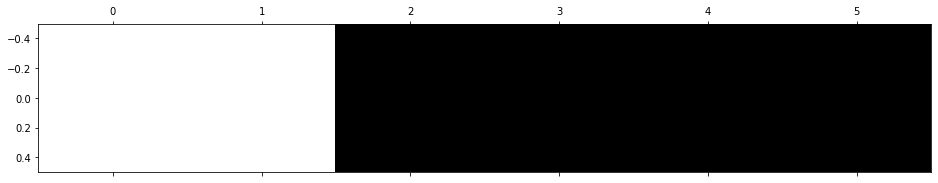

In [15]:
mask = select.get_support()

# Plot the mask. Black is True, White is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [16]:
normalized_VertB.columns.tolist()

[('GR',), ('ROP',), ('WOB',), ('RPM',), ('DT',), ('NPHI',)]

In [17]:
normalized_VertB_FS = pd.DataFrame(normalized_VertB_FS,columns=[['WOB', 'RPM', 'DT', 'NPHI']])

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, random_state=42, shuffle=True)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1232], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(SVR(), param_grid=param_grid, cv=cv, verbose=1, return_train_score=True, n_jobs=-1)

grid.fit(normalized_VertB_FS, y_VertB)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   48.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1232],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [19]:
print(grid.best_score_)
print(grid.best_params_)

0.2480901020213344
{'C': 1232, 'gamma': 1}


In [20]:
# Take the hyperparameter tuned model with RFE to predict RHOB for VertC.
hypertune_SVR = grid.predict(normalized_VertC[['WOB', 'RPM', 'DT', 'NPHI']])

In [21]:
# First we will use VertB to predict VertC and then VertC to predict VertB.
# We will now divide out data into a training and test sets using a rather handy function.
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

train_X_VertB, test_X_VertB, train_y_VertB, test_y_VertB = train_test_split(X_VertB, y_VertB, 
                                                    train_size=0.9,
                                                    test_size=0.1,
                                                    random_state=42)

train_X_VertC, test_X_VertC, train_y_VertC, test_y_VertC = train_test_split(X_VertC, y_VertC, 
                                                    train_size=0.9,
                                                    test_size=0.1,
                                                    random_state=42)

# We will use a neighbour based method for regression.
kneighbor_regression = KNeighborsRegressor(n_neighbors=5,n_jobs=-1)

kneighbor_regression.fit(train_X_VertB, train_y_VertB)
VertB_test = kneighbor_regression.predict(test_X_VertB)

# Now we take the model we just trained and use it to predict DT for VertC
VertC_Pred_DT_KNR = kneighbor_regression.predict(X_VertC)

# Now train on VertC to predict VertB
kneighbor_regression.fit(train_X_VertC, train_y_VertC)
VertC_test = kneighbor_regression.predict(test_X_VertC)
VertB_Pred_RHOB_KNR = kneighbor_regression.predict(X_VertB)

In [22]:
# Fit VertB and predict VertC
VertBtoVertC_RHOB = svr.fit(train_X_VertB, train_y_VertB)
VertC_Pred_RHOB = VertBtoVertC_RHOB.predict(normalized_VertC)

In [ ]:
x = VertC['DEPT']
y = VertC['RHOB']
z = VertC_Pred_RHOB
z1 = VertC_Pred_RHOB_KNR
z2 = hypertune_SVR

p = figure(title='VertC Predicted RHOB using SVR', plot_width=600, plot_height=400)
r = p.line(x, y, color='green', line_width=0.5,legend_label='RHOB')
r1 = p.line(x, z, color='blue', line_width=0.5,legend_label='Pred. RHOB SVR')
r2 = p.line(x, z1, color='red', line_width=0.5,legend_label='Pred. RHOB KNR')
r3 = p.line(x, z2, color='orange', line_width=0.5,legend_label='hypertune_SVR')

p.xaxis.axis_label = 'Depth (ft)'
p.yaxis.axis_label = 'Delta Time (ms/ft)'
p.legend.location = 'bottom_left'
show(p)